In [ ]:
!pip install transformers
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
from numpy import math
from numpy import loadtxt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Load Urdu BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

In [ ]:
import csv

In [ ]:


# Provide the path to the CSV file containing the text data
csv_file_path = '/content/Copy of Urdu Sentiment Analysis - Sheet1.csv'

# Open the CSV file
with open(csv_file_path, 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    total_words = 0

    # Iterate over each row in the CSV file
    for row in reader:
        # Assuming the text is present in a specific column, modify the index accordingly
        text = row[0]

        # Split the text into words
        words = text.split()

        # Count the number of words in the row
        num_words = len(words)

        # Add the number of words to the total count
        total_words += num_words

# Print the total number of words in the CSV file
print("Total words:", total_words)


Total words: 7299


In [ ]:
df= pd.read_csv('/content/Copy of Urdu Sentiment Analysis - Sheet1.csv')

In [ ]:
df.head()

,sentence,English Translation,Sentiment,Source,Index
0,محسوس تو گوگل ٹرانسلاٹ کا مودیفائد ورژن ہی ہوت...,It feels like a modified version of Google Tra...,Positive,https://www.write-urdu.com/,1.0
1,لکھنا شروع کریں,Start writing,Neutral,https://www.write-urdu.com/,0.0
2,اس انتظار سے کیا گلا جو تیرے دیدار پر ختم ہو,What is the throat of this waiting that ends w...,Negative,https://www.easynepalityping.com/type-urdu,-1.0
3,جشنِ چراغاں دیوالی کی دلی مبارکباد,Happy Diwali celebration,Positive,@Ishq_Urdu,1.0
4,کی پہلی پوزیشن کا انحصار انڈیا کی کارکردگی پر,India's first position depends on India's perf...,Neutral,Write Urdu,0.0


In [ ]:
df.dtypes

sentence                 object
English Translation      object
Sentiment                object
Source                   object
Index                   float64
dtype: object

In [ ]:
# Dataset Rows & Columns count
df.shape

(1201, 5)

In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sentence              1201 non-null   object 
 1   English Translation   1201 non-null   object 
 2   Sentiment             1200 non-null   object 
 3   Source                1199 non-null   object 
 4   Index                 1200 non-null   float64
dtypes: float64(1), object(4)
memory usage: 47.0+ KB


In [ ]:
# Define dataset class for Urdu sentiment analysis
class UrduSentimentDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.data = self.data[self.data['Index'].isin([0, 1])]  # Filter out samples with label 2
        self.texts = self.data['sentence'].tolist()
        self.labels = self.data['Index'].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded_input = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Custom collate function for DataLoader
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }


In [ ]:
def train_and_evaluate_model(file_path, batch_size=32, num_epochs=10, learning_rate=1e-5):
    # Load dataset
    dataset = UrduSentimentDataset(file_path)

    # Split dataset into train and validation sets
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)

    # Set up optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Training loop
    train_losses = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_predictions = 0
        correct_predictions = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            _, predicted_labels = torch.max(outputs.logits, dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

            loss.backward()
            optimizer.step()

        average_loss = total_loss / len(train_loader)
        train_losses.append(average_loss)
        train_accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")

        # Print train data
        if epoch == 0:
            print("\nTrain Data:")
            for i, data in enumerate(train_loader):
                print(f"Batch {i+1}/{len(train_loader)}")
                print("Input IDs:", data['input_ids'])
                print("Attention Mask:", data['attention_mask'])
                print("Labels:", data['labels'])
                if i == 2:  # Print the first 3 batches only for demonstration
                    break

        # Print validation data
        if epoch == 0:
            print("\nValidation Data:")
            for i, data in enumerate(val_loader):
                print(f"Batch {i+1}/{len(val_loader)}")
                print("Input IDs:", data['input_ids'])
                print("Attention Mask:", data['attention_mask'])
                print("Labels:", data['labels'])
                if i == 2:  # Print the first 3 batches only for demonstration
                    break

    # Evaluation loop
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    predicted_labels_all = []
    true_labels_all = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted_labels = torch.max(outputs.logits, dim=1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

            predicted_labels_all.extend(predicted_labels.cpu().numpy())
            true_labels_all.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    print(f"Validation Accuracy: {accuracy:.4f}")


    # Calculate F1 score
    f1 = f1_score(true_labels_all, predicted_labels_all, average='weighted')
    print(f"F1 Score: {f1:.4f}")


      # Confusion matrix
    cm = confusion_matrix(true_labels_all, predicted_labels_all)
    class_names = ['Negative', 'Positive']
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()

    # Histogram of train losses
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Train Losses')
    plt.show()

    # Line graph of test accuracy
    test_accuracy = accuracy
    train_accuracy = 1.0 - np.array(train_losses)
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_accuracy, 'b-', label='Train Accuracy')
    plt.plot(num_epochs, test_accuracy, 'r*', markersize=10, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy')
    plt.legend()
    plt.show()

    # Save the trained model
    model.save_pretrained("urdu_sentiment_model")


Enter the path to the training CSV file: /content/Copy of Urdu Sentiment Analysis - Sheet1.csv
Epoch 1/10 - Loss: 0.6762 - Train Accuracy: 0.5750

Train Data:
Batch 1/20
Input IDs: tensor([[  101,   793, 20451,  ...,     0,     0,     0],
        [  101, 10289, 24579,  ...,     0,     0,     0],
        [  101, 94656, 10388,  ...,     0,     0,     0],
        ...,
        [  101, 76295, 11722,  ...,     0,     0,     0],
        [  101,   788, 67108,  ...,     0,     0,     0],
        [  101,   793, 22468,  ...,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1])
Batch 2/20
Input IDs: tensor([[  101, 59901, 94607,  ...,     0,     0,     0],
        [  101,   770,

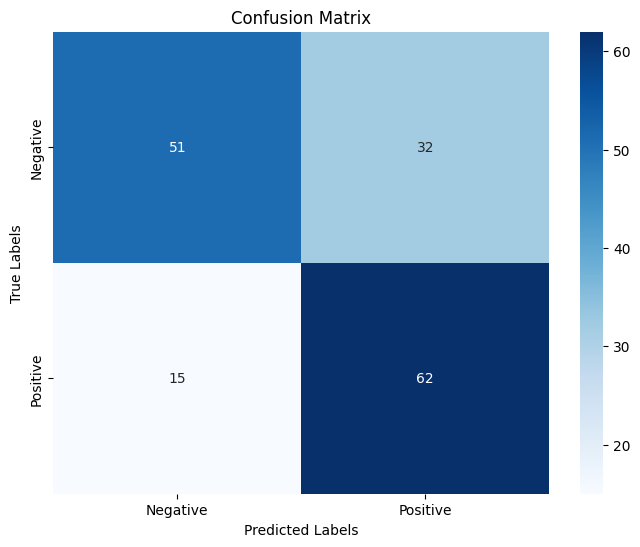

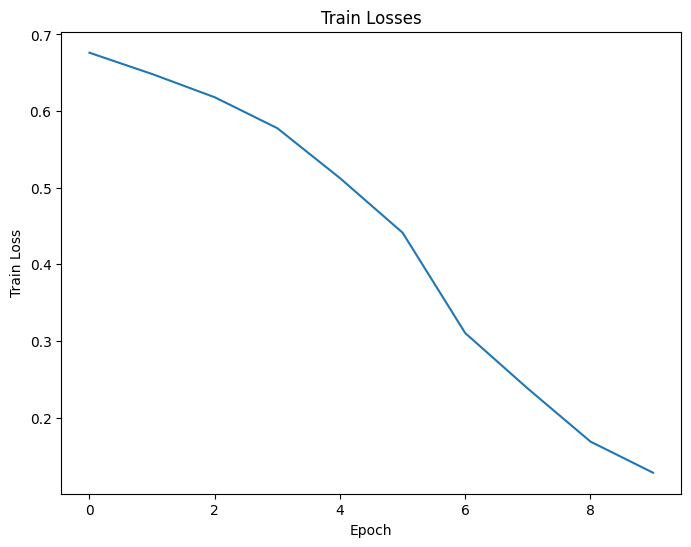

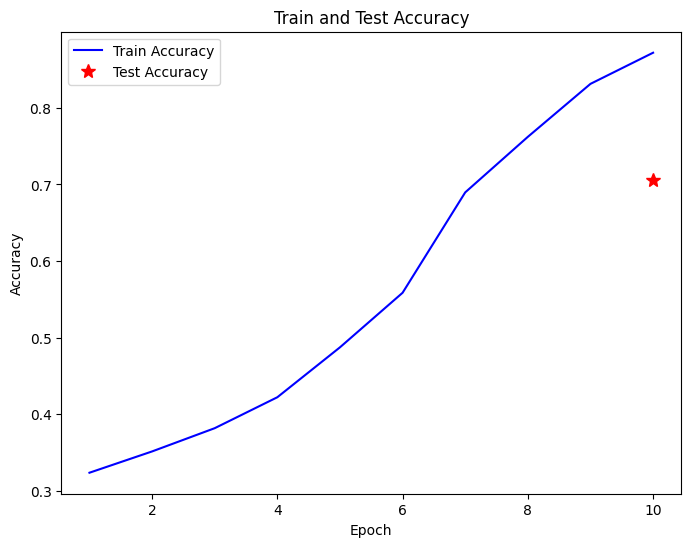

In [ ]:
# Run the training and evaluation
if __name__ == '__main__':
    file_path = input("Enter the path to the training CSV file: ")
    train_and_evaluate_model(file_path)